In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
import numpy as np

In [4]:
# Use this if you have all_plt_data.csv
all_plt_data = pd.read_csv('data/all_plt_data.csv')

# Else, read a filtered version of all_plt_data containing all dates for person 10 and person 161
# all_plt_data = pd.read_csv('data/demo_all_plt_data.csv')

## Kalman filtering for GPS data

#### Functions: 

`filter_person_and_date`- filters all_plt_data with a specific person and date

`kalman_filter`- adds two columns with filtered lat and long data

`plot_kalman_filtered_data` - plots difference between the observed gps data and filtered data

In [5]:
def filter_person_and_date(data, person, date):
    """
    Filter all_plt_data for a specific person and date.
    @param:
        data: all_plt_data df (or any df with c('person', 'lat', 'long', 'date', 'time') columns)
        person: int corresponding to the person (e.g. 161)
        date: str in the format 'YYYY-MM-DD'
    """
    person_data = data[data['person'] == person]
    person_data.loc[:, 'date'] = pd.to_datetime(person_data['date']).dt.date
    person_data = person_data[person_data['date'] == pd.to_datetime(date).date()]
    return person_data

### About pykalman:
Reference: https://pykalman.github.io/#basic-usage

The Kalman filter uses the following algorithm:
\begin{align*}
x_{t+1}   &= A_{t} x_{t} + b_{t} + \text{Normal}(0, Q_{t}) \\
z_{t}     &= C_{t} x_{t} + d_{t} + \text{Normal}(0, R_{t})
\end{align*}

State parameters:
- $x_t$ is the 'state', a given set of GPS coordinates $(\text{lat}, \text{long})$ at time $t$.
- $A_t$ is the state transition matrix to get from one $(\text{lat}, \text{long})$ to the next (how is this calculated?)
- $b_t$ is something

Noise parameters:
- $z_t$ is the 'noise' at any given state ???
- $B_t$ is the noise transition matrix to get from one noise to the next ????
- $d_t$ is also something 

**Kalman Smoother** (`kf.smooth`) is an algorithm designed to estimate the probability of a given $x_t=(\text{lat}, \text{long})$ given all the observations from $0$ to $T-1$.
- $P(x_t | z_{0:T-1})$

The **Expectation-Maximization (EM)** algorithm aims to find the KF parameters within the observations which have the 'max expectation' or the greatest probability of occurring given all the observations for all timesteps.
- Given: $\theta = (A, b, C, d, Q, R, \mu_0, \Sigma_0)$
- Want to find: $\max_{\theta} P(z_{0:T-1}; \theta)$

In [6]:
from pykalman import KalmanFilter
import numpy as np

def kalman_filtering(data):
    """ 
    Apply Kalman Filter to 'lat' and 'long' columns of the input df
    @param: 
        data: pd.DataFrame with 'lat' and 'long' columns
    @return: 
        df with 2 additional columns: 'lat_filtered' and 'long_filtered'
    """
    
    data_copy = data.copy()

    # Initialize Kalman Filter with initial lat/long (why?), with 2 dimensions
    initial_state_mean = [data_copy['lat'].iloc[0], 
                          data_copy['long'].iloc[0]]
    transition_matrix = [[1, 0], 
                         [0, 1]]
    observation_matrix = [[1, 0], 
                          [0, 1]]
    kf1 = KalmanFilter(transition_matrices=transition_matrix,
                      observation_matrices=observation_matrix,
                      initial_state_mean=initial_state_mean, 
                      n_dim_obs=2)

    # Use the 'lat' and 'long' columns as the observed values
    measurements = np.asarray(data_copy[['lat', 'long']])

    
    kf1 = kf1.em(measurements) # Use expectation-maximization to estimate the initial parameters
    (smoothed_state_means, smoothed_state_covariances) = kf1.smooth(measurements) # Apply Kalman smoothing

    kf2 = KalmanFilter(n_dim_obs=2, n_dim_state=2,
                      initial_state_mean=initial_state_mean,
                      initial_state_covariance = kf1.initial_state_covariance,
                      transition_matrices=transition_matrix,
                      observation_matrices=observation_matrix,
                      observation_covariance = kf1.observation_covariance,
                      transition_covariance = kf1.transition_covariance)
    
    kf2 = kf2.em(measurements)

    # Estimate the hidden states using all observations.  These estimates
    # will be 'smoother' (and are to be preferred) to those produced by
    # simply filtering as they are made with later observations in mind.
    # Probabilistically, this method produces the mean and covariance
    # characterizing,
    #    P(x_t | z_{1:n_timesteps})
    (smoothed_state_means2, smoothed_state_covariances2) = kf2.smooth(measurements)

    # Add the filtered latitude and longitude to the DataFrame
    data_copy.loc[:, 'lat_filtered'] = smoothed_state_means2[:, 0]
    data_copy.loc[:, 'long_filtered'] = smoothed_state_means2[:, 1]

    return data_copy

In [7]:
def plot_kalman_filtered_data(data):
    """ 
    Plot the observed vs. Kalman filtered lat/long data for a single person on a single day
    @param: 
        data: pd.DataFrame with 'lat', 'long', 'lat_filtered', and 'long_filtered' columns
        title: str, title of the plot
    @return: displays the plot, inline
    """

    # Make a copy of the data
    data_copy = data.copy()

    # Convert 'time' column to datetime
    data_copy['time_datetime'] = pd.to_datetime(data_copy['time'], format='%H:%M:%S')

    # Convert 'time' column to the total number of seconds past midnight
    data_copy['norm_time'] = data_copy['time_datetime'].dt.hour * 3600 + data_copy['time_datetime'].dt.minute * 60 + data_copy['time_datetime'].dt.second

    # Normalize the time for the color mapping
    norm_data = Normalize(data_copy['norm_time'].min(), data_copy['norm_time'].max())

    plt.figure(figsize=(10, 6))

    sc = plt.scatter(data_copy['long'], 
                    data_copy['lat'], 
                    c=data_copy['norm_time'], 
                    label='Observed data',
                    cmap='viridis', 
                    norm=norm_data)
    plt.colorbar(sc, label='Seconds since midnight')

    # plt.plot(data_copy['lat_filtered'], data_copy['long_filtered'], color='#e05343', label='Smoothed data', linewidth=3)
    sc_filter = plt.scatter(data_copy['long_filtered'], 
                            data_copy['lat_filtered'], 
                            # c=data_copy['norm_time'],
                            s=10,
                            color='#e05343',
                            # norm=norm_data,
                            label='Smoothed data')
    # plt.colorbar(sc_filter)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.ticklabel_format(useOffset=False, axis='y') # show raw long, not 0.022 or whatever
    plt.legend()
    plt.title(f'Kalman filtered: Person_{data_copy["person"].iloc[0]} location on {data_copy["date"].iloc[0]}')
    plt.show()

In [8]:
# Example: All walking data for person 161 on 2007-04-27
person161 = filter_person_and_date(all_plt_data, 161, '2007-04-27')
# person161_date04_27 # View

# Apply kalman filtering to person 161's data on 2007-04-27
person161 = kalman_filtering(person161)

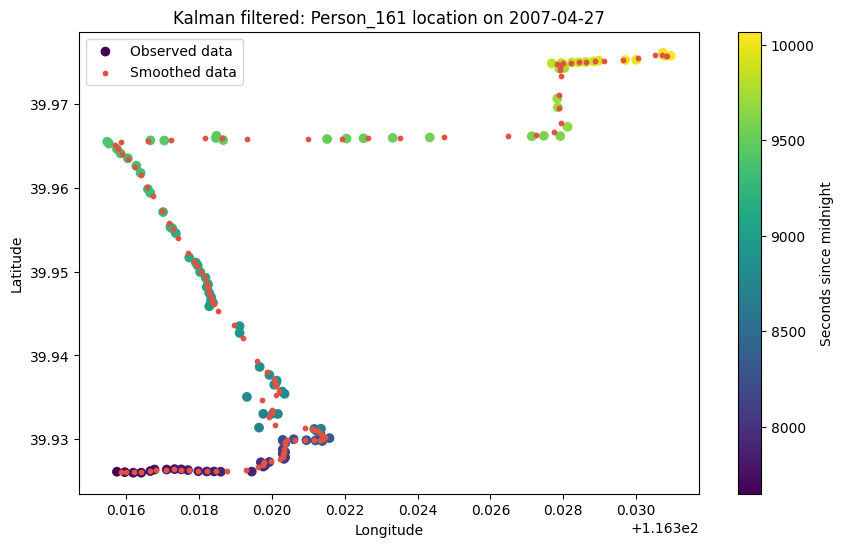

In [9]:
plot_kalman_filtered_data(person161)

In [10]:
# Try on some different people

print(all_plt_data['person'].unique())

[161 105 102 167  84  82  85  78  65  91  98  53  96  62  52  64  97 111
 144 128 117 153 126 136 138 163 107 139 108  73  20  89  87  80  81  86
  75  10  21  92  68  56  60  67  58 115 112 170 141 125 179]


In [11]:
# Find valid dates for all people
unique_dates = all_plt_data.groupby('person')['date'].unique().reset_index()
unique_dates

,person,date
0,10,"[2008-06-18, 2008-06-13, 2008-04-02, 2008-06-1..."
1,20,"[2011-09-03, 2011-09-07, 2011-09-02, 2011-08-2..."
2,21,"[2007-05-03, 2007-05-04]"
3,52,"[2008-06-28, 2008-06-29, 2008-06-21, 2008-10-1..."
4,53,"[2008-05-07, 2008-05-02, 2008-05-05, 2008-05-0..."
5,56,"[2007-11-08, 2007-10-17]"
6,58,"[2007-05-19, 2007-05-16, 2007-05-24, 2007-05-1..."
7,60,[2007-08-18]
8,62,"[2008-06-20, 2008-07-20, 2008-06-19, 2008-07-0..."
9,64,"[2008-08-16, 2008-08-17, 2008-08-18]"


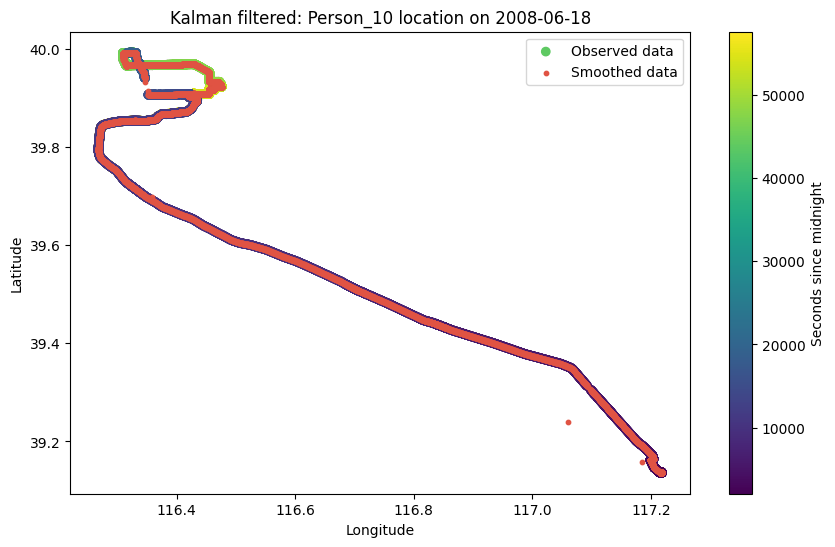

In [12]:
person10 = filter_person_and_date(all_plt_data, 10, '2008-06-18')
person10_kalman = kalman_filtering(person10)
plot_kalman_filtered_data(person10_kalman)

In [13]:
person10

,person,lat,long,zero,altitude,date_numb_days,date,time,cst_datetime,cst_weekday
1192381,10,39.991158,116.319451,0,220.0,39617.507326,2008-06-18,12:10:33,2008-06-18 20:10:33+08:00,2
1192382,10,39.991159,116.319470,0,220.0,39617.507338,2008-06-18,12:10:34,2008-06-18 20:10:34+08:00,2
1192383,10,39.991153,116.319495,0,220.0,39617.507350,2008-06-18,12:10:35,2008-06-18 20:10:35+08:00,2
1192384,10,39.991154,116.319518,0,220.0,39617.507373,2008-06-18,12:10:37,2008-06-18 20:10:37+08:00,2
1192385,10,39.991154,116.319531,0,220.0,39617.507384,2008-06-18,12:10:38,2008-06-18 20:10:38+08:00,2
...,...,...,...,...,...,...,...,...,...,...
1207051,10,39.991333,116.317588,0,299.0,39617.218900,2008-06-18,05:15:13,2008-06-18 13:15:13+08:00,2
1207052,10,39.991328,116.317433,0,302.0,39617.218924,2008-06-18,05:15:15,2008-06-18 13:15:15+08:00,2
1207053,10,39.991326,116.317381,0,302.0,39617.218935,2008-06-18,05:15:16,2008-06-18 13:15:16+08:00,2
1207054,10,39.991323,116.317344,0,302.0,39617.218947,2008-06-18,05:15:17,2008-06-18 13:15:17+08:00,2


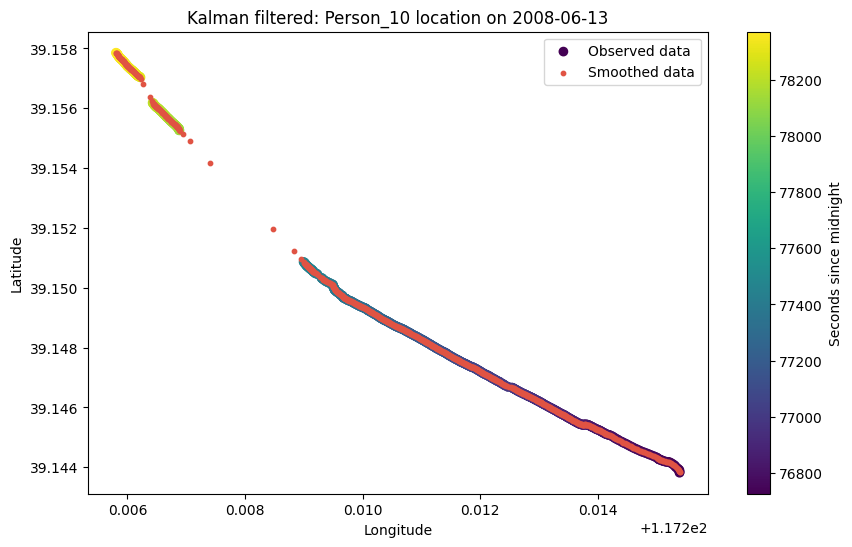

In [14]:
# Probably need to also filter for distinct times within a single day
person10_b = filter_person_and_date(all_plt_data, 10, '2008-06-13')
person10_b_kalman = kalman_filtering(person10_b)
plot_kalman_filtered_data(person10_b_kalman)

### Problem: Jump discontinuities?
- Should we find a way to account for these jumps? Or are those middle dot things ok?

- Maybe we can find way to label certain middle ones as missing? (See example [GitHub](https://github.com/pykalman/pykalman/blob/master/examples/standard/plot_missing.py))

In [15]:
# Code to create demo_all_plt_data.csv
def create_demo_all_plt_data():
    all_plt_data = pd.read_csv('data/all_plt_data.csv')
    filtered_all_plt_data = all_plt_data[(all_plt_data['person'] == 10) | (all_plt_data['person'] == 161)]
    filtered_all_plt_data.to_csv('data/demo_all_plt_data.csv')

In [ ]:
"""
TODO: 
- overlay geolife data onto map
- find examples of clear gps noise
- download geolife dataset and see if any unused cols?
    - or smaller datasets with ground truth
- integrate uoft data and/or video data to corroborate
"""